In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from plot_config import *
from utils import *

In [3]:
# rerun = True

In [4]:
if rerun:
    for name in ['domain4','domain_all']:
        if name == 'domain_all':
            print('all')
            ds = open_domain_all()
        else:
            print('4')
            ds = open_domain4()
        
        m = len(ds.space)
        n = len(ds.time)
        limit = 1825
        realigned = xr.Dataset()
        
        # %%time
        for var in ds.data_vars:
            print(var, end =' ')
            array = xr.DataArray(np.zeros((n-limit,limit)), dims = ('time','space'))
            for i in range(limit):
                array[:,i] = ds[var][limit-i:n-i,i]
            realigned[var] = array
        realigned.to_zarr('/sciserver/filedb08-03/ocean/wenrui_temp/realigned_cov_'+name,mode = 'w')

In [5]:
if rerun:
    for name in ['domain4','domain_all']:
        ns = xr.open_zarr('/sciserver/filedb08-03/ocean/wenrui_temp/realigned_cov_'+name)
        for var in rhs_list+region_names+['sum']:
            ns[var] = ns[var].cumsum(dim = 'space')
        
        Y = ns['sl'][:,0]
        EY2 = float(np.mean(Y*Y))
        
        the_covs = xr.Dataset()
        for var in rhs_list+region_names+['sf','sum']:
            the_covs[var] = (ns[var]*Y).mean(dim = 'time')/EY2
        the_covs.to_zarr('lineplotprep/dense_covdata_'+name,mode = 'w')

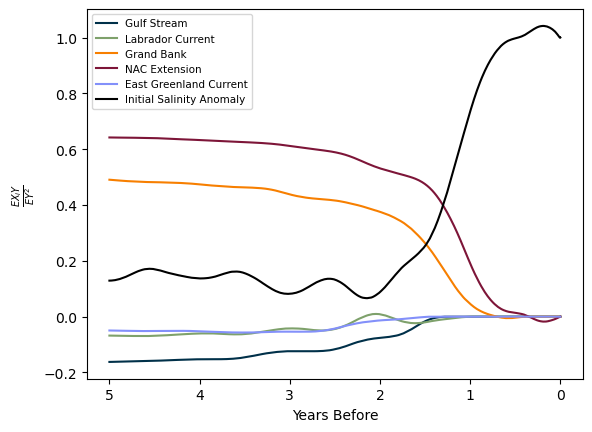

In [6]:
for name, (save1,save2) in [
    ('domain_all',('figure10(c).png', 'figure10(d).png')),
    ('domain4',('figure10(a).png', 'figure10(b).png')),
]:
    if name == 'domain_all':
        NUMBER_OF_PARTICLE = NUMBER_OF_PARTICLE_domain_all
    else:
        NUMBER_OF_PARTICLE = NUMBER_OF_PARTICLE_domain4
    plt.clf()
    the_covs = xr.open_zarr('lineplotprep/dense_covdata_'+name)
    covs = {}
    for var in the_covs.data_vars:
        covs[var]= np.array(the_covs[var])
    
    bins = 1
    n = 9497
    m = 1825#len(ds.space)
    size = (n//bins, m//bins)
    
    xs = np.arange(0,size[1]*1+1,1)/365
    for var in rhs_list+['sf']:
        if var == 'sf':
            plt.plot(xs,[1]+list(covs[var]),label = 'Initial Salinity Anomaly',color = 'k')
        else:
            plt.plot(xs,[0]+list(-covs[var]/NUMBER_OF_PARTICLE),label = term_dic[var],color = color_dic[var])
    plt.plot(xs,[0]+list(1-covs['sf']-(-covs['sum'])/NUMBER_OF_PARTICLE),color = error_color, label = 'Error')
    plt.xlabel('Years Before')
    plt.ylabel(r'$\frac{EX_iY}{EY^2}$')
    plt.legend(fontsize = 7.5)
    plt.savefig(save1)
    plt.clf()
    
    for var in region_names+['sf']:
        if var == 'sf':
            # pass
            plt.plot(xs,[1]+list(covs[var]),label = 'Initial Salinity Anomaly',color = 'k')
        else:
            plt.plot(xs,[0]+list(-covs[var]/NUMBER_OF_PARTICLE),label = region_longnames[var],color = region_colors[var])
    plt.xlabel('Years Before')
    plt.ylabel(r'$\frac{EX_iY}{EY^2}$')
    plt.legend(fontsize = 7.5)
    plt.gca().invert_xaxis()
    plt.savefig(save2,dpi = dpi)

In [7]:
# ds1 = open_domain_all()
# ds2 = open_domain4()

# ds1['A'][0,0].values

# ds2['A'][0,0].values

# name = 'domain_all'
# the_covs = xr.open_zarr('lineplotprep/dense_covdata_'+name)
# covs = {}
# for var in the_covs.data_vars:
#     covs[var]= np.array(the_covs[var])

# bins = 1
# n = 9497
# m = 1825#len(ds.space)
# size = (n//bins, m//bins)

# xs = np.arange(0,size[1]*50+1,50)/365
# for var in rhs_list+['sf']:
#     if var == 'sf':
#         plt.plot(xs,[1]+list(covs[var]),label = 'Initial Salinity Anomaly',color = 'k')
#     else:
#         plt.plot(xs,[0]+list(-covs[var]/NUMBER_OF_PARTICLE),label = term_dic[var],color = color_dic[var])
# plt.xlabel('Years Before')
# plt.ylabel(r'$\frac{EX_iY}{EY^2}$')
# plt.legend(fontsize = 8)